# ANÁLISE DA COVID-19 NO BRASIL

## BIBLIOTECAS E CONFIGURAÇÕES

In [32]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
from datetime            import datetime

In [33]:
sns.set_style('darkgrid')

## FUNÇÕES

In [34]:
# configura os eixos do gráfico
def axis_settings(x_label, y_label = ' ', fontsize = 12, x_rotation = 0, y_rotation = 0):
    plt.xlabel(x_label, fontsize = fontsize)
    plt.ylabel(y_label, fontsize = fontsize)
    plt.xticks(fontsize = fontsize, rotation = x_rotation)
    plt.yticks(fontsize = fontsize, rotation = y_rotation)

## 1. OBTENÇÃO DOS DADOS

In [9]:
# link do dataset
url = 'https://github.com/neylsoncrepalde/projeto_eda_covid/blob/master/covid_19_data.csv?raw=true'

# baixando os dados e armazenando em df
df = pd.read_csv(url, parse_dates = ['ObservationDate', 'Last Update'])

### 1.1. Renomeia as colunas

In [10]:
df.columns = ['sno', 'observation_date', 'province_state', 'country_region', 'last_update', 'confirmed', 
              'deaths', 'recovered']

## 2. DESCRIÇÃO DOS DADOS

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26713 entries, 0 to 26712
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   sno               26713 non-null  int64         
 1   observation_date  26713 non-null  datetime64[ns]
 2   province_state    12882 non-null  object        
 3   country_region    26713 non-null  object        
 4   last_update       26713 non-null  datetime64[ns]
 5   confirmed         26713 non-null  float64       
 6   deaths            26713 non-null  float64       
 7   recovered         26713 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(2)
memory usage: 1.6+ MB


- O conjunto de dados contém 26713 linhas e 8 colunas;
- A variável `province_state` possui dados faltantes;
- O conjunto de dados foram coletados a partir de 22/01/2020 à 19/05/2020.

## 3. ANÁLISES

In [28]:
# seleção dos dados do Brasil
br = df[df['country_region'] == 'Brazil'].reset_index(drop = True)

In [29]:
# serão mantidas na base os dados a partir do primeiro caso registrado no Brasil
br = br[br['confirmed'] > 0]

In [30]:
# seleção de colunas a serem analizadas
br = br[['observation_date', 'last_update', 'confirmed', 'deaths', 'recovered']]

### 3.1. Casos confirmados

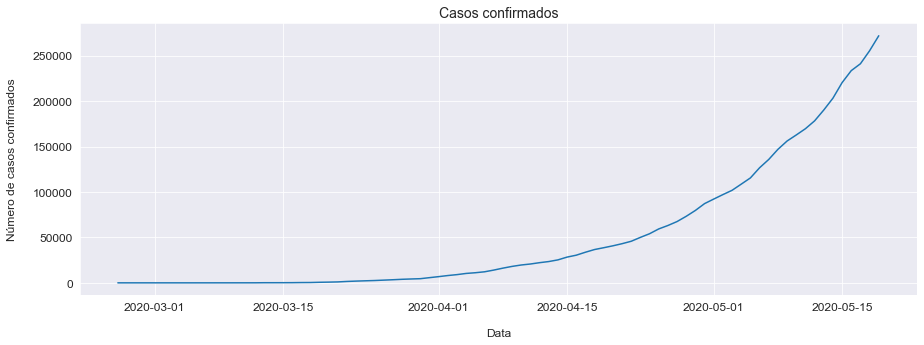

In [39]:
plt.figure(figsize = (15, 5))
sns.lineplot(data = br, x = 'observation_date', y = 'confirmed')
axis_settings('\nData', 'Número de casos confirmados\n')
plt.title('Casos confirmados', fontsize = 14)
plt.show()

Através do gráfico acima, é possível perceber que o número de casos cresce exponencialmente.

### 3.2. Número de novos casos por dia

In [43]:
# contabilização do número de novos casos 
br['novos_casos'] = list(map(lambda x: 0 if (x == 0) else br['confirmed'].iloc[x] - br['confirmed'].iloc[x-1],
                        np.arange(br.shape[0])))

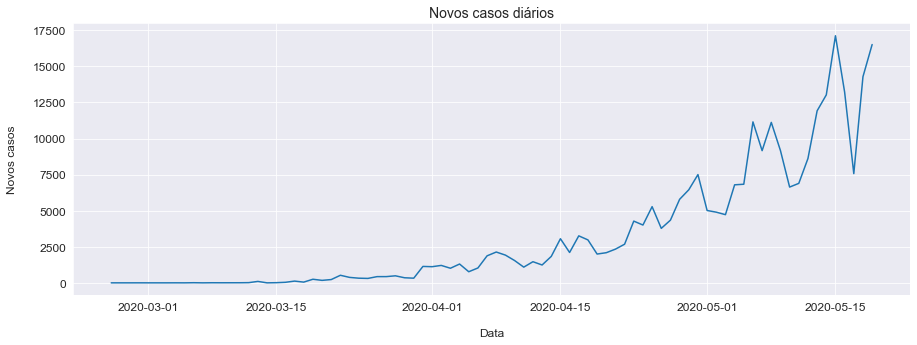

In [44]:
plt.figure(figsize = (15, 5))
sns.lineplot(data = br, x = 'observation_date', y = 'novos_casos')
axis_settings('\nData', 'Novos casos\n')
plt.title('Novos casos diários', fontsize = 14)
plt.show()

### 3.3. Quantidade de óbitos

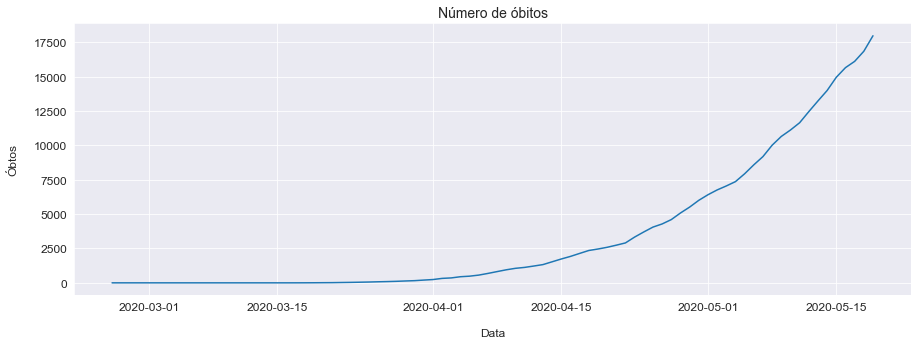

In [46]:
plt.figure(figsize = (15, 5))
sns.lineplot(data = br, x = 'observation_date', y = 'deaths')
axis_settings('\nData', 'Óbtos\n')
plt.title('Número de óbitos', fontsize = 14)
plt.show()

### 3.4. Taxa de crescimento médio

In [52]:
def taxa_crescimento(data, variable, data_inicio = None, data_fim = None):
    # se data_inicio for None, define como a primeira data disponível no dataset
    if data_inicio == None:
        data_inicio = data.observation_date.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    if data_fim == None:
        data_fim = data.observation_date.iloc[-1]
    else:
        data_fim = pd.to_datetime(data_fim)
    
    # define os valores de presente e passado
    passado = data.loc[data.observation_date == data_inicio, variable].values[0]
    presente = data.loc[data.observation_date == data_fim, variable].values[0]
    
    # define o número de pontos no tempo q vamos avaliar
    n = (data_fim - data_inicio).days
    
    # calcula a taxa
    taxa = (presente/passado)**(1/n) - 1

    return taxa*100

In [54]:
cresc_medio = taxa_crescimento(br, 'confirmed')
print(f'O crescimento médio do COVID no Brasil no período avaliado foi de {cresc_medio:.2f}%.')

O crescimento médio do COVID no Brasil no período avaliado foi de 16.27%.


### 3.5. Taxa de crescimento diário

In [55]:
def taxa_crescimento_diaria(data, variable, data_inicio = None):
    if data_inicio == None:
        data_inicio = data.observation_date.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    data_fim = data.observation_date.max()
    n = (data_fim - data_inicio).days
    
    taxas = list(map(lambda x: (data[variable].iloc[x] - data[variable].iloc[x-1]) / data[variable].iloc[x-1],
                                range(1,n+1)))
    
    return np.array(taxas)*100

In [56]:
tx_dia = taxa_crescimento_diaria(br, 'confirmed')

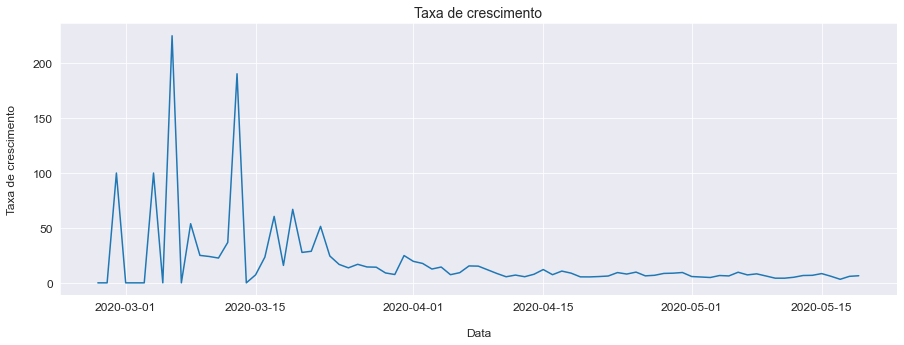

In [61]:
plt.figure(figsize = (15, 5))
primeiro_dia = br.observation_date.loc[br.confirmed > 0].min()
sns.lineplot(x = pd.date_range(primeiro_dia, br.observation_date.max())[1:], y = tx_dia)
axis_settings('\nData', 'Taxa de crescimento\n')
plt.title('Taxa de crescimento', fontsize = 14)
plt.show()

## 4. PREDIÇÕES